___
# **BME 5710 project report**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025 

___
### Provide descriptive answers at `???` locations and insert figures or tables at `?content?`

___
### Write your name below. 

Answer: Kate Herr

___
### Write the names of your teammates

Answer: Robert Smith, Luka Medvedovic, Kate Herr, Dhaarini Prasad-Sudha

___
### (1.1 -- 5%) Provide a layout of your CNN

#### The layout should provide all the necessary details about the CNN architecture including number of channels, size of convolution kernels, activation functions, etc. For inspiration, see examples [here](https://www.geeksforgeeks.org/u-net-architecture-explained/), [here](https://www.researchgate.net/figure/The-architecture-of-Unet_fig2_334287825), and [here](https://www.researchgate.net/figure/Modified-U-net-network-architecture_fig2_356216368)

Answer:

The resultant CNN we used for this process is an encoder-decoder-style CNN with two upscaling stages (using PixelShuffle), two skip connections, and a final downscaling stage to refine high-resolution outputs. The total upscaling performed is from 128 x 128 to 512 x 512, with the final output downsampled to 256x256. ReLU activation functions were used after every convolution step except the final output. Upsampling was done via PixelShuffle. Additionally, skip connections are used. Below is a detailed breakdown of the details for each of the main steps in the CNN architecture we used:

**Input:** 1 × 128 × 128 grayscale image

**Feature Extraction:**
| Layer | Type         | Channels | Kernel Size | Output Size      | Activation |
|-------|--------------|----------|-------------|------------------|------------|
| conv1 | Conv2D       | 1 → 80   | 3×3         | 80 × 128 × 128   | ReLU       |
| conv1b| Conv2D       | 80 → 80  | 3×3         | 80 × 128 × 128   | ReLU       |

**Upscaling Path 1:** (128 → 256)
| Layer               | Type           | Channels       | Kernel/Details  | Output Size      | Activation |
|--------------------|----------------|----------------|-----------------|------------------|------------|
| upscale1_conv      | Conv2D         | 80 → 320       | 3×3             | 320 × 128 × 128  | -          |
| pixel_shuffle1     | PixelShuffle   | 320 → 80       | Scale=2         | 80 × 256 × 256   | -          |
| conv2 + conv2b     | Conv2D         | 80 → 80 (×2)   | 3×3             | 80 × 256 × 256   | ReLU ×2    |
| bskip1             | Bicubic Upsamp.| 80 → 80        | Scale=2         | 80 × 256 × 256   | -          |
| concat + conv_after_skip1 → 1b | Conv2D (×2) | 160 → 80 → 80 | 3×3         | 80 × 256 × 256   | ReLU ×2    |

**Upscaling Path 2:** (256 → 512)
| Layer               | Type           | Channels       | Kernel/Details  | Output Size      | Activation |
|--------------------|----------------|----------------|-----------------|------------------|------------|
| upscale2_conv      | Conv2D         | 80 → 320       | 3×3             | 320 × 256 × 256  | -          |
| pixel_shuffle2     | PixelShuffle   | 320 → 80       | Scale=2         | 80 × 512 × 512   | -          |
| conv3 + conv3b     | Conv2D         | 80 → 80 (×2)   | 3×3             | 80 × 512 × 512   | ReLU ×2    |
| bskip2             | Bicubic Upsamp.| 80 → 80        | Scale=2         | 80 × 512 × 512   | -          |
| concat + conv_after_skip2 → 2b | Conv2D (×2) | 160 → 80 → 80 | 3×3         | 80 × 512 × 512   | ReLU ×2    |

**Downscaling Path:** (512 → 256)
| Layer   | Type     | Channels | Kernel Size | Output Size      | Activation |
|---------|----------|----------|-------------|------------------|------------|
| downscale | Conv2D | 80 → 80  | 2×2, Stride=2 | 80 × 256 × 256 | -          |
| conv4 + conv4b | Conv2D | 80 → 80 (×2) | 3×3     | 80 × 256 × 256 | ReLU ×2    |


**Output Layer:**
| Layer          | Type     | Channels | Kernel Size | Output Size    | Activation |
|----------------|----------|----------|-------------|----------------|------------|
| conv_out_final | Conv2D   | 80 → 1   | 3×3         | 1 × 256 × 256  | None       |

___
### (1.2 -- 1%) List *all* non-trivial features of your CNN and the training process. This may include use of dropout, learning rate scheduling, transfer learning, data augmentation, etc. Don't include items that are visible in the layout provided above.

Answer: 

**Skip Connections with Interpolation:** Low-level features from previous layers are interpolated using bicubic upsampling and added into deeper layers to keep spatial details.

**PixelShuffle for Upsampling:** Final feature maps are upscaled using PixelShuffle, which reduces checkerboard artifacts and produces sharper outputs compared to transposed convolutions.

**In-Place ReLU Activations:** ReLU activations are applied in-place to improve memory efficiency.

**Custom Loss Function (MSE + SSIM):** The loss function is a weighted combination of **Mean Squared Error (MSE)** and **Structural Similarity Index Measure (SSIM)** to balance numerical fidelity with perceptual quality.

**Validation Metric = PSNR + 40 × SSIM:** Model selection is based on a **custom validation score**, combining PSNR and SSIM into a single number for improved perceptual relevance.

**Data Augmentation:** To increase the amount of training data available for training the network, data augmentation was performed on the existing training images. Data was augmented either through rotation, mirroring, or a combination of the two:
- Rotation: 90, 180, or 270 degrees
- Mirroring: flipping along horizontal or vertical axis
- Combination: rotation by 90 and mirroring along either the horizontal or vertical axis

**Learning Rate Scheduler:** A ReduceLROnPlateau scheduler is used, reducing the learning rate by a factor of 0.05 if the validation score doesn't improve for 10 epochs.

**Early Stopping:** Training stops early if the validation score does not improve for **25 consecutive epochs** (patience-based early stopping).


___
### (2.1 -- 0.5%) Provide at least ten hyperparameters that you *could* optimize in your CNN design and training.

Answer: 
1. **Learning Rate:**  Control optimization step size; affects convergence speed/stability.

2. **Batch Size:** How many samples are processed before updating the model weights.

3. **Number of Epochs:** Too few may underfit, too many may overfit.

4. **Loss Function Weights (in this CNN, alpha and beta):** Balance MSE and SSIM in the custom loss function.

5. **Optimizer Choice:** I.e. Adam, SGD, RMSprop

6. **Learning Rate Scheduler Parameters:**  Scheduler patience (number of epochs to wait before reducing LR) and scheduler factor (multiplier to reduce LR)

7. **Upsampling Strategy:** I.e. PixelShuffle, transposed convolution, nearest-neighbor + conv,  etc.

8. **Dropout Rate:** Could be added and tuned to help reduce overfittingt.

9. **Kernel Sizes:**  Affects the model’s capacity; tradeoff between performance and computational cost.

10. **Data Augmentation Strategies:** Choosing different/more rotation angles, flipping, etc.

___
### (2.2 -- 0.5%) Now, list the hyperparameters that you *have* optimized.

Answer: 

1. **Learning Rate:**  Set to `1e-4` for the Adam optimizer

2. **Batch Size:**  Set to `8` based on available memory and convergence considerations

3. **Number of Epochs:**  Set to `200`; enough epochs for convergence without overfitting

4. **Loss Function Weights (alpha, beta):**  Set to `alpha = 0.6` and `beta = 0.4`, balancing contributions of (MSE) and (SSIM).

5. **Optimizer Choice:** Set as `Adam`, optimized for stable training with adaptive learning rates.

6. **Learning Rate Scheduler Parameters:**   `scheduler_patience = 10` and `scheduler_factor = 0.05`

7. **Early Stopping Patience:** Set to `25`; training will stop if no improvement in validation score for 25 epochs

8. **Kernel Sizes:**  Tradeoff between performance and computational cost 



___
### (2.3 -- 0.5%) Describe your strategy/approach for optimizing hyperparameters.

Answer: ???

___
### (2.4 -- 0.5%) What loss function did you use?  Express the loss function mathematically.

Answer: 

The combined loss is a weighted sum of Mean Squared Error (MSE) loss and Structural Similarity Index Measure (SSIM):

    CombinedLoss = alpha * MSE + beta * (1 - SSIM)

Where:
- `alpha` is the weight for the MSE loss.
- `beta` is the weight for the SSIM loss.
- `MSE` is the Mean Squared Error between the predicted and ground truth images.
- `SSIM` is the Structural Similarity Index between the predicted and ground truth images (clamped to [−1, 1]).

Lower MSE indicates better image quality, hence why MSE is minimized. Higher `SSIM` indicates better quality, which is why 1-SSIM is minimized. The predicted image is clamped between 0 and 1 before SSIM is computed.


___
### (2.5 -- 1%) Calculate the number of learnable parameters in your final CNN. How does that number compare with the number of training samples? Is your network overfitting or underfitting and how did you arrive at that conclusion? Explain that in the context of loss vs. epoch and/or performance metric vs. epoch curve for training and validation fold.

Parameters = (Kernel Height x Kernel Width x # In Channels x # Out Channels) + Bias

| Layer                         | In → Out Channels | Kernel Size | Parameters Calculation                 | Parameters |
|--------------------------------|-------------------|-------------|----------------------------------------|------------|
| conv1                          | 1 → 80            | 3×3         | (3×3×1×80) + 80 = 720 + 80             | 800        |
| conv1b                         | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| upscale1_conv                  | 80 → 320          | 3×3         | (3×3×80×320) + 320 = 230400 + 320      | 230720     |
| conv2                          | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| conv2b                         | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| conv_after_skip1               | 160 → 80          | 3×3         | (3×3×160×80) + 80 = 115200 + 80        | 115280     |
| conv_after_skip1b              | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| upscale2_conv                  | 80 → 320          | 3×3         | (3×3×80×320) + 320 = 230400 + 320      | 230720     |
| conv3                          | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| conv3b                         | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| conv_after_skip2               | 160 → 80          | 3×3         | (3×3×160×80) + 80 = 115200 + 80        | 115280     |
| conv_after_skip2b              | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| downscale_conv                 | 80 → 80           | 2×2 (stride=2) | (2×2×80×80) + 80 = 25600 + 80        | 25680      |
| conv4                          | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| conv4b                         | 80 → 80           | 3×3         | (3×3×80×80) + 80 = 57600 + 80          | 57680      |
| conv_out_final                 | 80 → 1            | 3×3         | (3×3×80×1) + 1 = 720 + 1               | 721        |

**Total Learnable Parameters:** **1,238,321**


 The model has a lot more parameters than training samples. It does not seem to be overfitting, as the validation score (related to both PSNR and SSIM) is generally improving throughout and only plateauing slightly at the end. The training loss is steadily decreasing as the epochs go on. It plateaus out a bit but still gradually lowers. The validation loss does spike slightly at 30 and 70 epochs and more significantly at 50 epochs, but it still steadily decreases and only fully plataeus around 100 epochs.

___
### (3.1 -- 5%) Insert (or draw using Markdown) a table that provides average values of PSNR, SSIM, and PSNR + 40xSSIM for (i) interpolated low-resolution images, (ii) images super-resolved with the TrivialNet model included in `starter_code.ipynb`, and (iii) images super-resolved with your CNN. Include the metrics from training, validation, and test folds.

PSNR, SSIM, and Combined Score metrics from the **training**, **validation**, and **test** folds.

| Method                    | Fold       | PSNR (↑) | SSIM (↑) | PSNR + 40×SSIM (↑) |
|--------------------------|------------|----------|----------|---------------------|
| Interpolated LR          | Training   | 30.50    | 0.9116   | 66.69               |
|                          | Validation | 31.00    | 0.9074   | 67.30               |
|                          | Test       | 30.80    | 0.9192   | 67.57               |
| TrivialNet               | Training   | XX.XX    | 0.XXXX   | XX.XX               |
|                          | Validation | XX.XX    | 0.XXXX   | XX.XX               |
|                          | Test       | XX.XX    | 0.XXXX   | XX.XX               |
| Your CNN                 | Training   | 36.02    | 0.9669   | 74.69               |
|                          | Validation | 36.63    | 0.9655   | 75.25               |
|                          | Test       | 36.61    | 0.9717   | 75.48               |


___
### (3.2 -- 1%) When it comes to comparing images, what does SSIM capture that PSNR does not?

Answer: SSIM is able to better capture the quality of how an image is perceived since it takes into account factors like local patterns, brightness, contrast, etc. while PSNR measures error purely from pixel to pixel.

___
### (4.1 -- 4%) Display a figure where the first row (from left to right) shows an example of high-resolution image, interpolated low-resolution image, image super-resolved with TrivialNet, and the image super-resolved with your CNN, and the second row shows corresponding error maps after 5-fold amplification. For this figure, you may select any image from the test dataset.

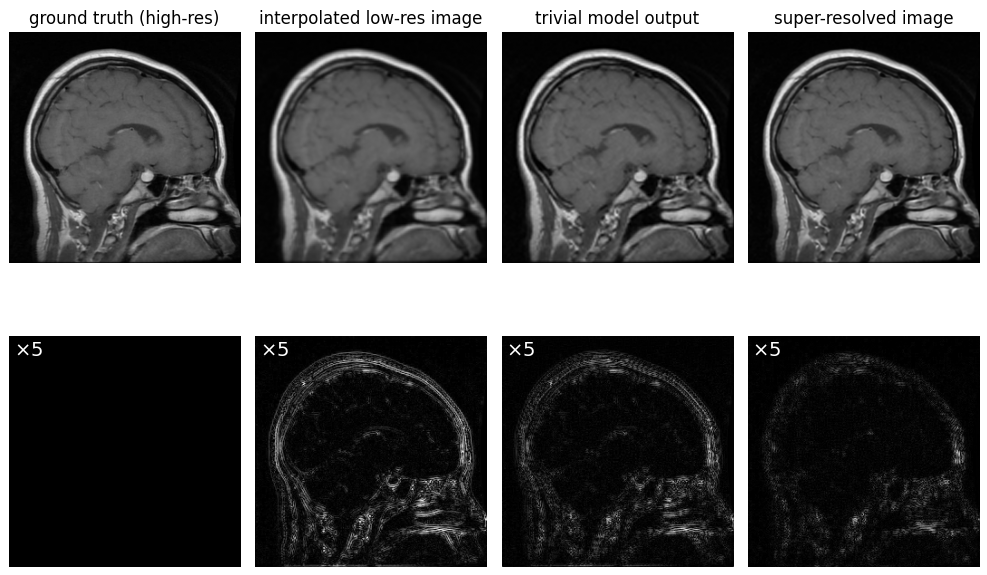

___
### (4.2 -- 1%) From (4.1), subjectively identify which image features are well-preserved by your CNN and which are lost. Additionally, describe how you could further improve the performance of your model if given more time and resources.

Answer: Many of the features inside the cranial space are well-preserved, especiallythe brain/its folds. However, regions below eye-level (nose, nasal cavity, mouth, etc). look to be not quite as well preserved. To further performance of this model, larger batch sizes could be implemented, as described in the paper Dr. Ahmad referenced. However, because of the memory limit, it was challenging to train the model on these larger batch sizes as some models were hitting the upper limit of what the vram on my GPU could handle.